<a href="https://colab.research.google.com/github/sundarjhu/Astrostatistics2025/blob/main/Lesson_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dynesty ultranest pymc arviz pytensor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 15.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.9/102.9 kB 5.2 MB/s eta 0:00:00
  Created wheel for ultranest: filename=ultranest-4.4.0-cp312-cp312-linux_x86_64.whl size=2325092 sha256=759a1a48d8ae8fece47c6ee2b3aba5954e2107e72a7d1e74060c31b1ea44e1fa
  Stored in directory: /root/.cache/pip/wheels/d9/d6/ac/232c612794767c59c73f1e551fd0a285bfedbb8f1202f71934
Successfully built ultranest



# Frequentist vs Bayesian Model Selection: Quadratic vs Quintic Fits

This notebook demonstrates model selection using both **frequentist** (AIC/BIC) and **Bayesian** (marginal likelihood) methods.  
We generate synthetic data from a quadratic model and compare a quadratic and a quintic polynomial fit.

The Bayesian evidence is computed robustly using **nested sampling** (`dynesty`, `UltraNest`), while **PyMC's SMC** evidence is shown with caveats about its limitations.



## 1. Generate Synthetic Data


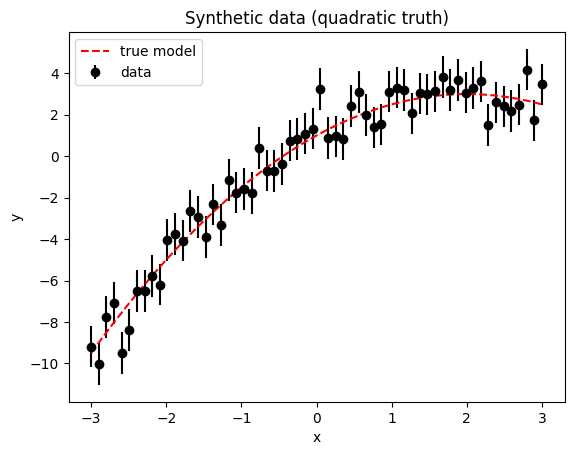

In [2]:

import numpy as np, matplotlib.pyplot as plt

rng = np.random.default_rng(42)
x = np.linspace(-3, 3, 60)
y_true = 1 + 2*x - 0.5*x**2
yerr = np.ones_like(x)
y = y_true + rng.normal(0, yerr)

plt.errorbar(x, y, yerr, fmt='o', color='k', label='data')
plt.plot(x, y_true, 'r--', label='true model')
plt.xlabel('x'); plt.ylabel('y'); plt.legend()
plt.title('Synthetic data (quadratic truth)')
plt.show()



## 2. Frequentist Fits: Quadratic and Quintic

Compute AIC and BIC to compare models under frequentist assumptions.


In [3]:

from scipy.optimize import curve_fit

def fit_poly(x, y, yerr, deg):
    p0 = np.zeros(deg+1)
    popt, pcov = curve_fit(lambda x,*p: np.polyval(p,x), x, y, sigma=yerr, p0=p0)
    return popt, pcov

def chi2(p):
    return np.sum(((y - np.polyval(p, x))/yerr)**2)

p2, c2 = fit_poly(x, y, yerr, 2)
p5, c5 = fit_poly(x, y, yerr, 5)

chi2_2, chi2_5 = chi2(p2), chi2(p5)
n = len(y)
k2, k5 = len(p2), len(p5)

AIC2, AIC5 = 2*k2 + chi2_2, 2*k5 + chi2_5
BIC2, BIC5 = k2*np.log(n) + chi2_2, k5*np.log(n) + chi2_5

print(f"AIC: quadratic={AIC2:.1f}, quintic={AIC5:.1f}")
print(f"BIC: quadratic={BIC2:.1f}, quintic={BIC5:.1f}")


AIC: quadratic=41.6, quintic=47.4
BIC: quadratic=47.9, quintic=60.0



## 3. Bayesian Evidence via Nested Sampling (dynesty)


In [4]:

import dynesty

def loglike(theta):
    model = np.polyval(theta, x)
    return -0.5*np.sum(((y - model)/yerr)**2)

def prior_transform(u):
    return 20*(u - 0.5)

logZ_dynesty = {}
for deg in [2, 5]:
    ndim = deg + 1
    sampler = dynesty.NestedSampler(loglike, prior_transform, ndim, nlive=300)
    sampler.run_nested()
    res = sampler.results
    logZ_dynesty[deg] = res.logz[-1]
    print(f"dynesty logZ (deg {deg}) = {res.logz[-1]:.2f} ± {res.logzerr[-1]:.2f}")


4539it [00:16, 271.36it/s, +300 | bound: 20 | nc: 1 | ncall: 16816 | eff(%): 29.299 | loglstar:   -inf < -17.820 <    inf | logz: -31.674 +/-  0.208 | dlogz:  0.001 >  0.309]


dynesty logZ (deg 2) = -31.67 ± 0.31


9831it [00:21, 447.54it/s, +300 | bound: 78 | nc: 1 | ncall: 33986 | eff(%): 30.075 | loglstar:   -inf < -17.975 <    inf | logz: -49.504 +/-  0.319 | dlogz:  0.001 >  0.309]

dynesty logZ (deg 5) = -49.50 ± 0.46



## 4. Bayesian Evidence via UltraNest (quiet mode)


In [5]:

import ultranest, logging, os, contextlib

def loglike_ultra(theta):
    model = np.polyval(theta, x)
    return -0.5*np.sum(((y - model)/yerr)**2)

def prior_ultra(u):
    return 20*(u - 0.5)

# Silence most output
logger = logging.getLogger("ultranest")
logger.setLevel(logging.WARNING)

logZ_ultra = {}
for deg in [2, 5]:
    names = [f"a{i}" for i in range(deg+1)]
    sampler = ultranest.ReactiveNestedSampler(names, loglike_ultra, transform=prior_ultra)
    with open(os.devnull, 'w') as f, contextlib.redirect_stderr(f):
        result = sampler.run(min_num_live_points=300, dlogz=0.1, show_status=False, viz_callback=False)
    logZ_ultra[deg] = result['logz']
    print(f"UltraNest logZ (deg {deg}) = {result['logz']:.2f} ± {result['logzerr']:.2f}")


DEBUG:ultranest:ReactiveNestedSampler: dims=3+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] To achieve the desired logz accuracy, min_num_live_points was increased to 317


INFO:ultranest:To achieve the desired logz accuracy, min_num_live_points was increased to 317


[ultranest] Sampling 317 live points from prior ...


INFO:ultranest:Sampling 317 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.1, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=317, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(317.0)), (np.float64(inf), np.float64(317.0))]
DEBUG:ultranest:iteration=0, ncalls=318, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-72308.49, Lmax=-367.67
DEBUG:ultranest:iteration=32, ncalls=353, regioncalls=1440, ndraw=40, logz=-46989.22, remainder_fraction=100.0000%, Lmin=-46428.59, Lmax=-262.60
DEBUG:ultranest:iteration=64, ncalls=391, regioncalls=2960, ndraw=40, logz=-36551.25, remainder_fraction=100.0000%, Lmin=-36505.72, Lmax=-262.60
DEBUG:ultranest:iteration=71, ncalls=401, regioncalls=3360, ndraw=40, logz=-35459.21, remainder_fraction=100.0000%, Lmin=-35182.05, Lmax=-262.60
DEBUG:ultranest:iteration=96, ncall

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 10063


INFO:ultranest:Likelihood function evaluations: 10063
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -31.57 +- 0.2049


INFO:ultranest:  logZ = -31.57 +- 0.2049


[ultranest] Effective samples strategy satisfied (ESS = 1515.2, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1515.2, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 783 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 316 and 316, most (4348/4349 iterations) have 315


[ultranest] Evidency uncertainty strategy wants 783 minimum live points (dlogz from 0.16 to 0.47, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 783 minimum live points (dlogz from 0.16 to 0.47, need <0.1)


[ultranest]   logZ error budget: single: 0.20 bs:0.20 tail:0.01 total:0.21 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.20 bs:0.20 tail:0.01 total:0.21 required:<0.10


[ultranest] Widening roots to 783 live points (have 317 already) ...


INFO:ultranest:Widening roots to 783 live points (have 317 already) ...


[ultranest] Sampling 466 live points from prior ...


INFO:ultranest:Sampling 466 live points from prior ...
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(783.0)), (np.float64(inf), np.float64(783.0))]
DEBUG:ultranest:iteration=0, ncalls=10530, regioncalls=393560, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-72891.03, Lmax=-17.82
DEBUG:ultranest:iteration=32, ncalls=10553, regioncalls=394480, ndraw=40, logz=-59424.44, remainder_fraction=100.0000%, Lmin=-59052.91, Lmax=-17.82
DEBUG:ultranest:iteration=128, ncalls=10619, regioncalls=397120, ndraw=40, logz=-43446.53, remainder_fraction=100.0000%, Lmin=-43306.76, Lmax=-17.82
DEBUG:ultranest:iteration=187, ncalls=10664, regioncalls=398920, ndraw=40, logz=-37478.96, remainder_fraction=100.0000%, Lmin=-37469.12, Lmax=-17.82
DEBUG:ultranest:iteration=224, ncalls=10697, regioncalls=400240, ndraw=40, logz=-34525.00, remainder_fraction=100.0000%, Lmin=-34463.98, Lmax=-17.82
DEBUG:ultranest:iteration=256, ncalls=10720, regioncalls=401160, ndraw=40, logz=-32263.25

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 23809


INFO:ultranest:Likelihood function evaluations: 23809
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -32.01 +- 0.08728


INFO:ultranest:  logZ = -32.01 +- 0.08728


[ultranest] Effective samples strategy satisfied (ESS = 3739.8, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 3739.8, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 1244 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 782 and 782, most (9831/9832 iterations) have 781


[ultranest] Evidency uncertainty strategy wants 1244 minimum live points (dlogz from 0.08 to 0.18, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 1244 minimum live points (dlogz from 0.08 to 0.18, need <0.1)


[ultranest]   logZ error budget: single: 0.13 bs:0.09 tail:0.01 total:0.09 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.13 bs:0.09 tail:0.01 total:0.09 required:<0.10


[ultranest] Widening roots to 1244 live points (have 783 already) ...


INFO:ultranest:Widening roots to 1244 live points (have 783 already) ...


[ultranest] Sampling 461 live points from prior ...


INFO:ultranest:Sampling 461 live points from prior ...
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(1244.0)), (np.float64(inf), np.float64(1244.0))]
DEBUG:ultranest:iteration=0, ncalls=24271, regioncalls=930080, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-75772.33, Lmax=-17.82
DEBUG:ultranest:iteration=120, ncalls=24316, regioncalls=931880, ndraw=40, logz=-51115.19, remainder_fraction=100.0000%, Lmin=-51027.16, Lmax=-17.82
DEBUG:ultranest:iteration=128, ncalls=24318, regioncalls=931960, ndraw=40, logz=-49824.89, remainder_fraction=100.0000%, Lmin=-49796.10, Lmax=-17.82
DEBUG:ultranest:iteration=246, ncalls=24368, regioncalls=933960, ndraw=40, logz=-40148.36, remainder_fraction=100.0000%, Lmin=-40121.78, Lmax=-17.82
DEBUG:ultranest:iteration=279, ncalls=24380, regioncalls=934440, ndraw=40, logz=-38238.91, remainder_fraction=100.0000%, Lmin=-38230.03, Lmax=-17.82
DEBUG:ultranest:iteration=288, ncalls=24384, regioncalls=934600, ndraw=40, logz=-37827

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 36983


INFO:ultranest:Likelihood function evaluations: 36983
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -31.93 +- 0.07204


INFO:ultranest:  logZ = -31.93 +- 0.07204


[ultranest] Effective samples strategy satisfied (ESS = 5898.6, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 5898.6, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 1565 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 1243 and 1243, most (17961/17962 iterations) have 1242


[ultranest] Evidency uncertainty strategy wants 1565 minimum live points (dlogz from 0.06 to 0.13, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 1565 minimum live points (dlogz from 0.06 to 0.13, need <0.1)


[ultranest]   logZ error budget: single: 0.10 bs:0.07 tail:0.01 total:0.07 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.10 bs:0.07 tail:0.01 total:0.07 required:<0.10


[ultranest] Widening roots to 1565 live points (have 1244 already) ...


INFO:ultranest:Widening roots to 1565 live points (have 1244 already) ...


[ultranest] Sampling 321 live points from prior ...


INFO:ultranest:Sampling 321 live points from prior ...
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(1565.0)), (np.float64(inf), np.float64(1565.0))]
DEBUG:ultranest:iteration=0, ncalls=37305, regioncalls=1443080, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-80634.53, Lmax=-17.82
DEBUG:ultranest:iteration=154, ncalls=37334, regioncalls=1444240, ndraw=40, logz=-50136.12, remainder_fraction=100.0000%, Lmin=-49970.16, Lmax=-17.82
DEBUG:ultranest:iteration=224, ncalls=37348, regioncalls=1444800, ndraw=40, logz=-44727.87, remainder_fraction=100.0000%, Lmin=-44578.91, Lmax=-17.82
DEBUG:ultranest:iteration=320, ncalls=37365, regioncalls=1445480, ndraw=40, logz=-39265.03, remainder_fraction=100.0000%, Lmin=-39205.64, Lmax=-17.82
DEBUG:ultranest:iteration=354, ncalls=37369, regioncalls=1445640, ndraw=40, logz=-37622.26, remainder_fraction=100.0000%, Lmin=-37555.90, Lmax=-17.82
DEBUG:ultranest:iteration=384, ncalls=37385, regioncalls=1446280, ndraw=40, logz=

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 46195


INFO:ultranest:Likelihood function evaluations: 46195
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -31.97 +- 0.0684


INFO:ultranest:  logZ = -31.97 +- 0.0684


[ultranest] Effective samples strategy satisfied (ESS = 7444.7, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 7444.7, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 1760 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 1564 and 1564, most (27801/27802 iterations) have 1563


[ultranest] Evidency uncertainty strategy wants 1760 minimum live points (dlogz from 0.06 to 0.17, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 1760 minimum live points (dlogz from 0.06 to 0.17, need <0.1)


[ultranest]   logZ error budget: single: 0.09 bs:0.07 tail:0.01 total:0.07 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.09 bs:0.07 tail:0.01 total:0.07 required:<0.10


[ultranest] Widening roots to 1760 live points (have 1565 already) ...


INFO:ultranest:Widening roots to 1760 live points (have 1565 already) ...


[ultranest] Sampling 195 live points from prior ...


INFO:ultranest:Sampling 195 live points from prior ...
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(1760.0)), (np.float64(inf), np.float64(1760.0))]
DEBUG:ultranest:iteration=2, ncalls=46391, regioncalls=1803120, ndraw=40, logz=-78274.34, remainder_fraction=100.0000%, Lmin=-75779.23, Lmax=-17.82
DEBUG:ultranest:iteration=164, ncalls=46408, regioncalls=1803800, ndraw=40, logz=-50735.72, remainder_fraction=100.0000%, Lmin=-50727.88, Lmax=-17.82
DEBUG:ultranest:iteration=224, ncalls=46424, regioncalls=1804440, ndraw=40, logz=-46436.19, remainder_fraction=100.0000%, Lmin=-46386.57, Lmax=-17.82
DEBUG:ultranest:iteration=370, ncalls=46445, regioncalls=1805280, ndraw=40, logz=-38834.73, remainder_fraction=100.0000%, Lmin=-38800.17, Lmax=-17.82
DEBUG:ultranest:iteration=395, ncalls=46448, regioncalls=1805400, ndraw=40, logz=-37912.89, remainder_fraction=100.0000%, Lmin=-37904.38, Lmax=-17.82
DEBUG:ultranest:iteration=416, ncalls=46451, regioncalls=1805520, ndraw=40, 

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 51358


INFO:ultranest:Likelihood function evaluations: 51358
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -31.91 +- 0.06988


INFO:ultranest:  logZ = -31.91 +- 0.06988


[ultranest] Effective samples strategy satisfied (ESS = 8379.8, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 8379.8, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 1864 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 1759 and 1759, most (24276/24277 iterations) have 1758
DEBUG:ultranest:  at least 1758 live points are needed to reach dlogz goal


[ultranest] Evidency uncertainty strategy wants 1758 minimum live points (dlogz from 0.06 to 0.17, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 1758 minimum live points (dlogz from 0.06 to 0.17, need <0.1)


[ultranest]   logZ error budget: single: 0.09 bs:0.07 tail:0.01 total:0.07 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.09 bs:0.07 tail:0.01 total:0.07 required:<0.10


[ultranest] done iterating.


INFO:ultranest:done iterating.
DEBUG:ultranest:ReactiveNestedSampler: dims=6+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


UltraNest logZ (deg 2) = -31.92 ± 0.17
[ultranest] To achieve the desired logz accuracy, min_num_live_points was increased to 317


INFO:ultranest:To achieve the desired logz accuracy, min_num_live_points was increased to 317


[ultranest] Sampling 317 live points from prior ...


INFO:ultranest:Sampling 317 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.1, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=317, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(317.0)), (np.float64(inf), np.float64(317.0))]
DEBUG:ultranest:iteration=0, ncalls=318, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-23274571.10, Lmax=-11991.39
DEBUG:ultranest:iteration=32, ncalls=350, regioncalls=1320, ndraw=40, logz=-17748144.72, remainder_fraction=100.0000%, Lmin=-17683351.63, Lmax=-11991.39
DEBUG:ultranest:iteration=64, ncalls=385, regioncalls=2720, ndraw=40, logz=-14191581.13, remainder_fraction=100.0000%, Lmin=-14052820.85, Lmax=-11991.39
DEBUG:ultranest:iteration=96, ncalls=421, regioncalls=4160, ndraw=40, logz=-11940370.86, remainder_fraction=100.0000%, Lmin=-11493694.28, Lmax=-11991.39
DEBUG:

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 35384


INFO:ultranest:Likelihood function evaluations: 35384
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -50.27 +- 0.2097


INFO:ultranest:  logZ = -50.27 +- 0.2097


[ultranest] Effective samples strategy satisfied (ESS = 1966.9, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1966.9, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 1095 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 316 and 316, most (9999/10000 iterations) have 315


[ultranest] Evidency uncertainty strategy wants 1095 minimum live points (dlogz from 0.18 to 0.51, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 1095 minimum live points (dlogz from 0.18 to 0.51, need <0.1)


[ultranest]   logZ error budget: single: 0.31 bs:0.21 tail:0.01 total:0.21 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.31 bs:0.21 tail:0.01 total:0.21 required:<0.10


[ultranest] Widening roots to 1095 live points (have 317 already) ...


INFO:ultranest:Widening roots to 1095 live points (have 317 already) ...


[ultranest] Sampling 778 live points from prior ...


INFO:ultranest:Sampling 778 live points from prior ...
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(1095.0)), (np.float64(inf), np.float64(1095.0))]
DEBUG:ultranest:iteration=0, ncalls=36163, regioncalls=1421480, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-23813948.92, Lmax=-17.75
DEBUG:ultranest:iteration=62, ncalls=36198, regioncalls=1422880, ndraw=40, logz=-18412621.44, remainder_fraction=100.0000%, Lmin=-18318200.94, Lmax=-17.75
DEBUG:ultranest:iteration=96, ncalls=36226, regioncalls=1424000, ndraw=40, logz=-17187273.50, remainder_fraction=100.0000%, Lmin=-17156292.37, Lmax=-17.75
DEBUG:ultranest:iteration=138, ncalls=36260, regioncalls=1425360, ndraw=40, logz=-15690860.19, remainder_fraction=100.0000%, Lmin=-15688299.66, Lmax=-17.75
DEBUG:ultranest:iteration=187, ncalls=36305, regioncalls=1427160, ndraw=40, logz=-14437519.11, remainder_fraction=100.0000%, Lmin=-14399678.97, Lmax=-17.75
DEBUG:ultranest:iteration=192, ncalls=36309, regioncalls

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 98517


INFO:ultranest:Likelihood function evaluations: 98517
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -49.74 +- 0.1425


INFO:ultranest:  logZ = -49.74 +- 0.1425


[ultranest] Effective samples strategy satisfied (ESS = 6989.1, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 6989.1, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 2023 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 1094 and 1094, most (32030/32031 iterations) have 1093


[ultranest] Evidency uncertainty strategy wants 2023 minimum live points (dlogz from 0.13 to 0.30, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 2023 minimum live points (dlogz from 0.13 to 0.30, need <0.1)


[ultranest]   logZ error budget: single: 0.16 bs:0.14 tail:0.01 total:0.14 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.16 bs:0.14 tail:0.01 total:0.14 required:<0.10


[ultranest] Widening roots to 2023 live points (have 1095 already) ...


INFO:ultranest:Widening roots to 2023 live points (have 1095 already) ...


[ultranest] Sampling 928 live points from prior ...


INFO:ultranest:Sampling 928 live points from prior ...
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(2023.0)), (np.float64(inf), np.float64(2023.0))]
DEBUG:ultranest:iteration=0, ncalls=99446, regioncalls=3933680, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-26107008.04, Lmax=-17.74
DEBUG:ultranest:iteration=73, ncalls=99478, regioncalls=3934960, ndraw=40, logz=-20070450.02, remainder_fraction=100.0000%, Lmin=-20055295.92, Lmax=-17.74
DEBUG:ultranest:iteration=128, ncalls=99510, regioncalls=3936240, ndraw=40, logz=-18230579.39, remainder_fraction=100.0000%, Lmin=-18219892.76, Lmax=-17.74
DEBUG:ultranest:iteration=160, ncalls=99526, regioncalls=3936880, ndraw=40, logz=-17597028.89, remainder_fraction=100.0000%, Lmin=-17593687.99, Lmax=-17.74
DEBUG:ultranest:iteration=192, ncalls=99542, regioncalls=3937520, ndraw=40, logz=-17000782.38, remainder_fraction=100.0000%, Lmin=-16994013.61, Lmax=-17.74
DEBUG:ultranest:iteration=255, ncalls=99580, regioncall

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 167032


INFO:ultranest:Likelihood function evaluations: 167032
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -49.65 +- 0.07756


INFO:ultranest:  logZ = -49.65 +- 0.07756


[ultranest] Effective samples strategy satisfied (ESS = 12867.8, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 12867.8, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 2746 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 2022 and 2022, most (58340/58341 iterations) have 2021


[ultranest] Evidency uncertainty strategy wants 2746 minimum live points (dlogz from 0.07 to 0.19, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 2746 minimum live points (dlogz from 0.07 to 0.19, need <0.1)


[ultranest]   logZ error budget: single: 0.12 bs:0.08 tail:0.01 total:0.08 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.12 bs:0.08 tail:0.01 total:0.08 required:<0.10


[ultranest] Widening roots to 2746 live points (have 2023 already) ...


INFO:ultranest:Widening roots to 2746 live points (have 2023 already) ...


[ultranest] Sampling 723 live points from prior ...


INFO:ultranest:Sampling 723 live points from prior ...
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(2746.0)), (np.float64(inf), np.float64(2746.0))]
DEBUG:ultranest:iteration=4, ncalls=167756, regioncalls=6655320, ndraw=40, logz=-24007474.46, remainder_fraction=100.0000%, Lmin=-23867584.77, Lmax=-17.72
DEBUG:ultranest:iteration=32, ncalls=167764, regioncalls=6655640, ndraw=40, logz=-21810752.72, remainder_fraction=100.0000%, Lmin=-21795125.11, Lmax=-17.72
DEBUG:ultranest:iteration=112, ncalls=167782, regioncalls=6656360, ndraw=40, logz=-19784689.72, remainder_fraction=100.0000%, Lmin=-19768752.65, Lmax=-17.72
DEBUG:ultranest:iteration=128, ncalls=167789, regioncalls=6656640, ndraw=40, logz=-19383518.28, remainder_fraction=100.0000%, Lmin=-19345303.23, Lmax=-17.72
DEBUG:ultranest:iteration=189, ncalls=167811, regioncalls=6657520, ndraw=40, logz=-18106659.31, remainder_fraction=100.0000%, Lmin=-18103689.93, Lmax=-17.72
DEBUG:ultranest:iteration=192, ncalls=1678

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 218897


INFO:ultranest:Likelihood function evaluations: 218897
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -49.61 +- 0.08677


INFO:ultranest:  logZ = -49.61 +- 0.08677


[ultranest] Effective samples strategy satisfied (ESS = 17478.5, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 17478.5, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 3197 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 2745 and 2745, most (84365/84366 iterations) have 2744


[ultranest] Evidency uncertainty strategy wants 3197 minimum live points (dlogz from 0.07 to 0.19, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 3197 minimum live points (dlogz from 0.07 to 0.19, need <0.1)


[ultranest]   logZ error budget: single: 0.10 bs:0.09 tail:0.01 total:0.09 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.10 bs:0.09 tail:0.01 total:0.09 required:<0.10


[ultranest] Widening roots to 3197 live points (have 2746 already) ...


INFO:ultranest:Widening roots to 3197 live points (have 2746 already) ...


[ultranest] Sampling 451 live points from prior ...


INFO:ultranest:Sampling 451 live points from prior ...
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(3197.0)), (np.float64(inf), np.float64(3197.0))]
DEBUG:ultranest:iteration=2, ncalls=219349, regioncalls=8720560, ndraw=40, logz=-25264414.59, remainder_fraction=100.0000%, Lmin=-24727853.78, Lmax=-17.72
DEBUG:ultranest:iteration=97, ncalls=219361, regioncalls=8721040, ndraw=40, logz=-20230263.97, remainder_fraction=100.0000%, Lmin=-20227195.69, Lmax=-17.72
DEBUG:ultranest:iteration=160, ncalls=219370, regioncalls=8721400, ndraw=40, logz=-18977842.40, remainder_fraction=100.0000%, Lmin=-18977206.41, Lmax=-17.72
DEBUG:ultranest:iteration=243, ncalls=219380, regioncalls=8721800, ndraw=40, logz=-17705243.89, remainder_fraction=100.0000%, Lmin=-17701851.62, Lmax=-17.72
DEBUG:ultranest:iteration=320, ncalls=219391, regioncalls=8722240, ndraw=40, logz=-16952447.64, remainder_fraction=100.0000%, Lmin=-16943840.50, Lmax=-17.72
DEBUG:ultranest:iteration=398, ncalls=2194

[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 250690


INFO:ultranest:Likelihood function evaluations: 250690
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -49.63 +- 0.0657


INFO:ultranest:  logZ = -49.63 +- 0.0657


[ultranest] Effective samples strategy satisfied (ESS = 20364.2, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 20364.2, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 3449 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 3196 and 3196, most (88796/88797 iterations) have 3195
DEBUG:ultranest:  at least 3195 live points are needed to reach dlogz goal


[ultranest] Evidency uncertainty strategy wants 3195 minimum live points (dlogz from 0.05 to 0.14, need <0.1)


INFO:ultranest:Evidency uncertainty strategy wants 3195 minimum live points (dlogz from 0.05 to 0.14, need <0.1)


[ultranest]   logZ error budget: single: 0.10 bs:0.07 tail:0.01 total:0.07 required:<0.10


INFO:ultranest:  logZ error budget: single: 0.10 bs:0.07 tail:0.01 total:0.07 required:<0.10


[ultranest] done iterating.


INFO:ultranest:done iterating.


UltraNest logZ (deg 5) = -49.60 ± 0.14



## 5. PyMC (SMC) Evidence — with caveats

PyMC's Sequential Monte Carlo sampler estimates the log-evidence (`log_marginal_likelihood`),  
but in recent versions this value may be unavailable or `NaN`.

We check it explicitly and report if it's missing.  
For robust Bayesian model comparison, **dynesty** and **UltraNest** should be preferred.


In [6]:

import pymc as pm, pytensor.tensor as pt, arviz as az

def pymc_model(deg):
    with pm.Model() as model:
        coeff = pm.Normal("coeff", 0, 10, shape=deg + 1)
        mu = pt.zeros_like(x)
        for i, c in enumerate(coeff):
            mu += c * x ** (deg - i)
        sigma = pm.HalfNormal("sigma", 1)
        pm.Normal("y", mu=mu, sigma=sigma, observed=y)
    return model

logZ_pymc = {}
for deg in [2, 5]:
    model = pymc_model(deg)
    with model:
        idata = pm.sample_smc(draws=2000, chains=1, progressbar=False, return_inferencedata=True)
        logZ = idata.sample_stats.attrs.get("log_marginal_likelihood", np.nan)
        if np.isnan(logZ):
            print(f"Warning: PyMC logZ for degree {deg} is NaN (may not be computed).\n"
                  "This is expected in PyMC >= 5.12 when the sampler does not record evidence.")
        logZ_pymc[deg] = logZ
        print(f"PyMC logZ (deg {deg}) = {logZ:.2f}")


This is expected in PyMC >= 5.12 when the sampler does not record evidence.
PyMC logZ (deg 2) = nan
This is expected in PyMC >= 5.12 when the sampler does not record evidence.
PyMC logZ (deg 5) = nan



## 6. Compare Evidences and Interpret


In [8]:

logZs = {'dynesty': logZ_dynesty, 'ultranest': logZ_ultra, 'pymc': logZ_pymc}
for method, vals in logZs.items():
    if len(vals) == 2:
        lnB = vals[2] - vals[5]
        print(f"{method:8s}: DeltalnB = {lnB:.2f}")


dynesty : DeltalnB = 17.83
ultranest: DeltalnB = 17.68
pymc    : DeltalnB = nan



## 7. Discussion
- Dynesty and UltraNest produce consistent evidence values.
- PyMC's evidence field is often NaN due to current API limitations.
- Nested sampling is the robust and recommended way to compute Bayesian evidence.

| Δln Z | Strength of Evidence |
|:------:|:--------------------|
| < 1 | Inconclusive |
| 1–2.5 | Weak |
| 2.5–5 | Moderate |
| > 5 | Strong |

In this dataset (quadratic truth), all samplers should favor the quadratic model.
